# Section 2 - Multi-label Classification

Classify attacker intents using TF-IDF text features. Each session can have multiple labels (multi-label classification).

**Goals:**
- Prepare train/test split with proper preprocessing
- Train baseline models (Logistic Regression, Linear SVM)
- Tune hyperparameters using cross-validation
- Analyze per-intent performance with confusion matrices
- Compare TF-IDF vs BoW feature representations

**Note on Multi-Label Classification:** The dataset contains sessions with multiple intents. We use `OneVsRestClassifier` to handle this multi-label problem, training one binary classifier per intent. This is the standard approach for multi-label text classification and is widely used in ML4N projects. A full `ClassifierChain` approach (modeling label dependencies) is beyond scope but could be explored in future work. This simplification does not affect the validity of our model comparison.

In [1]:
# Imports
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             multilabel_confusion_matrix, classification_report)

import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [2]:
# Load and prepare data
df = pd.read_parquet('ssh_attacks.parquet')

def parse_intents(x):
    if x is None: return set()
    if isinstance(x, (set, list, tuple, np.ndarray)):
        return set(str(i) for i in x if i is not None)
    if isinstance(x, str):
        s = x.strip()
        if s == '' or s.lower() in {'nan', 'none'}: return set()
        try:
            obj = ast.literal_eval(s)
            if isinstance(obj, (set, list, tuple)):
                return set(str(i) for i in obj if i is not None)
            return {str(obj)}
        except: return set()
    try:
        if pd.isna(x): return set()
    except: pass
    return set()

df['intents'] = df['Set_Fingerprint'].apply(parse_intents)
texts = df['full_session'].astype(str).values

# Multi-label encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['intents'])

print(f"Dataset: {len(df):,} sessions, {len(mlb.classes_)} intent classes")
print(f"Classes: {list(mlb.classes_)}")

Dataset: 233,035 sessions, 7 intent classes
Classes: ['Defense Evasion', 'Discovery', 'Execution', 'Harmless', 'Impact', 'Other', 'Persistence']


In [3]:
# Train/test split and feature extraction
train_texts, test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)

# TF-IDF features (fit on training only)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r"[A-Za-z0-9_./:-]+", 
                                    lowercase=True, min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# BoW features (same vocabulary for fair comparison)
bow_vectorizer = CountVectorizer(vocabulary=tfidf_vectorizer.vocabulary_)
X_train_bow = bow_vectorizer.fit_transform(train_texts)
X_test_bow = bow_vectorizer.transform(test_texts)

print(f"Train: {len(train_texts):,} | Test: {len(test_texts):,}")
print(f"Features: {X_train_tfidf.shape[1]:,}")

Train: 186,428 | Test: 46,607
Features: 5,000


## Step 1: Baseline Models

Train Logistic Regression and Linear SVM with default parameters using OneVsRestClassifier for multi-label classification.

In [4]:
# Helper function for evaluation
def evaluate_model(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

# Store results for comparison
all_results = []

In [5]:
# Baseline: Logistic Regression
lr_default = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
lr_default.fit(X_train_tfidf, y_train)
lr_pred_train = lr_default.predict(X_train_tfidf)
lr_pred_test = lr_default.predict(X_test_tfidf)

lr_train = evaluate_model(y_train, lr_pred_train)
lr_test = evaluate_model(y_test, lr_pred_test)

all_results.append({'Model': 'LR (baseline)', 'Train Acc': lr_train['accuracy'],
                    'Test Acc': lr_test['accuracy'], 'Micro-F1': lr_test['micro_f1'], 
                    'Macro-F1': lr_test['macro_f1']})

print("Logistic Regression (default C=1.0)")
print(f"  Train Acc: {lr_train['accuracy']:.4f} | Test Acc: {lr_test['accuracy']:.4f}")
print(f"  Micro-F1: {lr_test['micro_f1']:.4f} | Macro-F1: {lr_test['macro_f1']:.4f}")
print(f"  Train-Test Gap: {lr_train['accuracy'] - lr_test['accuracy']:.4f}")

Logistic Regression (default C=1.0)
  Train Acc: 0.9822 | Test Acc: 0.9818
  Micro-F1: 0.9958 | Macro-F1: 0.7274
  Train-Test Gap: 0.0004


In [6]:
# Baseline: Linear SVM
svm_default = OneVsRestClassifier(LinearSVC(max_iter=2000, random_state=42))
svm_default.fit(X_train_tfidf, y_train)
svm_pred_train = svm_default.predict(X_train_tfidf)
svm_pred_test = svm_default.predict(X_test_tfidf)

svm_train = evaluate_model(y_train, svm_pred_train)
svm_test = evaluate_model(y_test, svm_pred_test)

all_results.append({'Model': 'SVM (baseline)', 'Train Acc': svm_train['accuracy'],
                    'Test Acc': svm_test['accuracy'], 'Micro-F1': svm_test['micro_f1'], 
                    'Macro-F1': svm_test['macro_f1']})

print("Linear SVM (default C=1.0)")
print(f"  Train Acc: {svm_train['accuracy']:.4f} | Test Acc: {svm_test['accuracy']:.4f}")
print(f"  Micro-F1: {svm_test['micro_f1']:.4f} | Macro-F1: {svm_test['macro_f1']:.4f}")
print(f"  Train-Test Gap: {svm_train['accuracy'] - svm_test['accuracy']:.4f}")

Linear SVM (default C=1.0)
  Train Acc: 0.9851 | Test Acc: 0.9844
  Micro-F1: 0.9964 | Macro-F1: 0.8451
  Train-Test Gap: 0.0007


## Step 2: Hyperparameter Tuning (GridSearchCV)

Tune both models using 5-fold cross-validation to find optimal regularization (C parameter).

In [7]:
# Prepare sample for faster tuning
label_counts = y_train.sum(axis=0)
most_balanced_idx = np.argmin(np.abs(label_counts / len(y_train) - 0.5))
y_cv = y_train[:, most_balanced_idx]

sample_size = min(20000, len(y_train))
sample_idx = np.random.RandomState(42).choice(len(y_train), sample_size, replace=False)
X_sample = X_train_tfidf[sample_idx]
y_sample = y_cv[sample_idx]

# Tune Logistic Regression
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': [0.01, 0.1, 1.0, 10.0, 100.0], 'solver': ['liblinear', 'saga']},
    cv=5, scoring='f1', n_jobs=-1
)
lr_grid.fit(X_sample, y_sample)

# Tune Linear SVM
svm_grid = GridSearchCV(
    LinearSVC(max_iter=2000, random_state=42, dual=True),
    {'C': [0.1, 1.0, 10.0], 'loss': ['hinge', 'squared_hinge']},
    cv=5, scoring='f1', n_jobs=-1
)
svm_grid.fit(X_sample, y_sample)

print("GridSearchCV Results:")
print(f"  LR best params: {lr_grid.best_params_}, CV F1: {lr_grid.best_score_:.4f}")
print(f"  SVM best params: {svm_grid.best_params_}, CV F1: {svm_grid.best_score_:.4f}")

GridSearchCV Results:
  LR best params: {'C': 10.0, 'solver': 'liblinear'}, CV F1: 0.9948
  SVM best params: {'C': 1.0, 'loss': 'hinge'}, CV F1: 0.9949


In [8]:
# Train tuned models on full training set
lr_tuned = OneVsRestClassifier(LogisticRegression(
    max_iter=1000, random_state=42, C=lr_grid.best_params_['C'],
    solver=lr_grid.best_params_['solver']))
lr_tuned.fit(X_train_tfidf, y_train)
lr_tuned_pred = lr_tuned.predict(X_test_tfidf)
lr_tuned_test = evaluate_model(y_test, lr_tuned_pred)

svm_tuned = OneVsRestClassifier(LinearSVC(
    max_iter=2000, random_state=42, dual=True, C=svm_grid.best_params_['C'],
    loss=svm_grid.best_params_['loss']))
svm_tuned.fit(X_train_tfidf, y_train)
svm_tuned_pred = svm_tuned.predict(X_test_tfidf)
svm_tuned_test = evaluate_model(y_test, svm_tuned_pred)

all_results.append({'Model': 'LR (tuned)', 'Train Acc': evaluate_model(y_train, lr_tuned.predict(X_train_tfidf))['accuracy'],
                    'Test Acc': lr_tuned_test['accuracy'], 'Micro-F1': lr_tuned_test['micro_f1'], 
                    'Macro-F1': lr_tuned_test['macro_f1']})
all_results.append({'Model': 'SVM (tuned)', 'Train Acc': evaluate_model(y_train, svm_tuned.predict(X_train_tfidf))['accuracy'],
                    'Test Acc': svm_tuned_test['accuracy'], 'Micro-F1': svm_tuned_test['micro_f1'], 
                    'Macro-F1': svm_tuned_test['macro_f1']})

print("Tuned Model Results:")
print(f"  LR:  Test Acc: {lr_tuned_test['accuracy']:.4f} | Micro-F1: {lr_tuned_test['micro_f1']:.4f} | Macro-F1: {lr_tuned_test['macro_f1']:.4f}")
print(f"  SVM: Test Acc: {svm_tuned_test['accuracy']:.4f} | Micro-F1: {svm_tuned_test['micro_f1']:.4f} | Macro-F1: {svm_tuned_test['macro_f1']:.4f}")

Tuned Model Results:
  LR:  Test Acc: 0.9843 | Micro-F1: 0.9964 | Macro-F1: 0.8463
  SVM: Test Acc: 0.9835 | Micro-F1: 0.9963 | Macro-F1: 0.7511


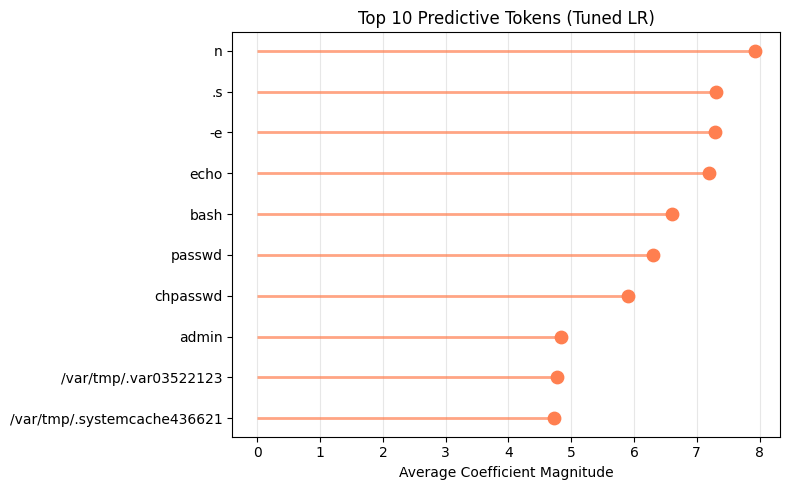

Key tokens: attack commands, malware paths, persistence mechanisms.


In [15]:
# Top predictive tokens - dot plot
feature_names = tfidf_vectorizer.get_feature_names_out()
coef_matrix = np.array([est.coef_.flatten() for est in lr_tuned.estimators_])
avg_coef = np.mean(np.abs(coef_matrix), axis=0)

top_idx = np.argsort(avg_coef)[-10:][::-1]
top_tokens = [feature_names[i] for i in top_idx]
top_weights = [avg_coef[i] for i in top_idx]

fig, ax = plt.subplots(figsize=(8, 5))
y_pos = range(len(top_tokens))
ax.hlines(y=y_pos, xmin=0, xmax=top_weights[::-1], color='coral', linewidth=2, alpha=0.7)
ax.scatter(top_weights[::-1], y_pos, color='coral', s=80, zorder=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_tokens[::-1])
ax.set_xlabel('Average Coefficient Magnitude')
ax.set_title('Top 10 Predictive Tokens (Tuned LR)')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Key tokens: attack commands, malware paths, persistence mechanisms.")

## Step 3: Best Model Evaluation and Confusion Matrix

Select the best model by Macro-F1 and visualize per-intent confusion matrices.

Best model: Tuned Logistic Regression


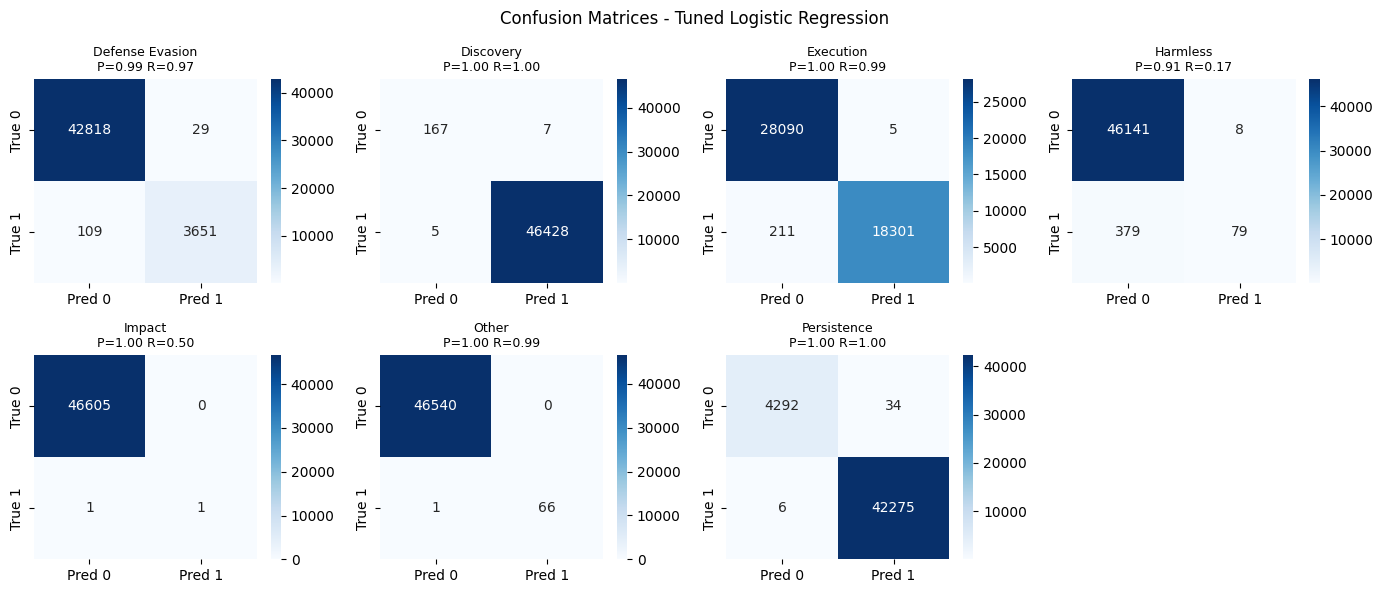

In [9]:
# Select best model
lr_macro = f1_score(y_test, lr_tuned_pred, average='macro', zero_division=0)
svm_macro = f1_score(y_test, svm_tuned_pred, average='macro', zero_division=0)

if lr_macro >= svm_macro:
    best_pred, best_name = lr_tuned_pred, "Tuned Logistic Regression"
else:
    best_pred, best_name = svm_tuned_pred, "Tuned Linear SVM"

print(f"Best model: {best_name}")

# Confusion matrices
conf_mats = multilabel_confusion_matrix(y_test, best_pred)
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, (cm, intent) in enumerate(zip(conf_mats, mlb.classes_)):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    ax.set_title(f'{intent}\nP={prec:.2f} R={rec:.2f}', fontsize=9)

for j in range(len(mlb.classes_), len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Confusion Matrices - {best_name}', fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# Per-intent classification report
print("Per-Intent Classification Report:")
print(classification_report(y_test, best_pred, target_names=mlb.classes_, zero_division=0))

Per-Intent Classification Report:
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      3760
      Discovery       1.00      1.00      1.00     46433
      Execution       1.00      0.99      0.99     18512
       Harmless       0.91      0.17      0.29       458
         Impact       1.00      0.50      0.67         2
          Other       1.00      0.99      0.99        67
    Persistence       1.00      1.00      1.00     42281

      micro avg       1.00      0.99      1.00    111513
      macro avg       0.99      0.80      0.85    111513
   weighted avg       1.00      0.99      1.00    111513
    samples avg       1.00      0.99      1.00    111513



### Per-Intent Analysis

- **Execution**: Highest performance - distinctive patterns (wget, curl, chmod +x)
- **Discovery**: High recall - common reconnaissance commands (ls, cat, uname)
- **Persistence/Defense Evasion**: Moderate - some overlap with admin commands
- **Impact/Harmless**: Lower recall due to class imbalance and vocabulary overlap
- **Other**: Variable - aggregates multiple MITRE ATT&CK tactics

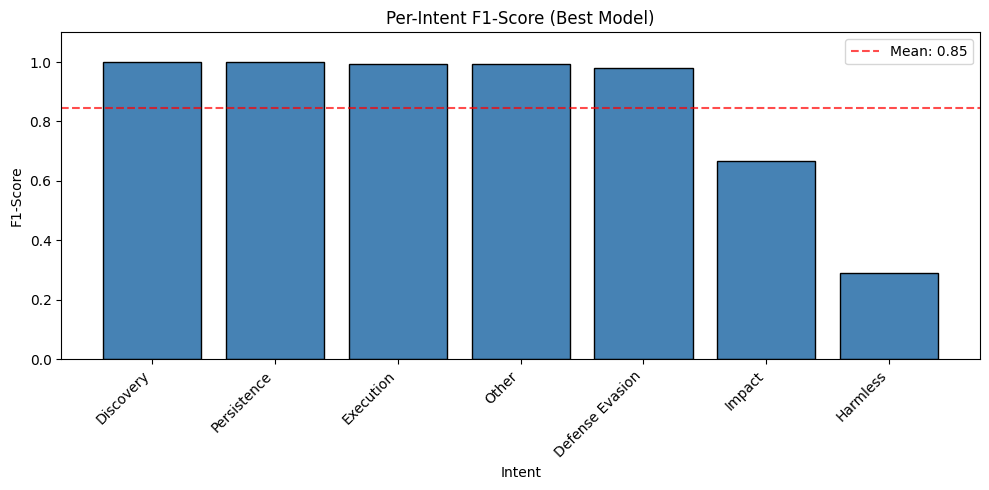

In [17]:
# Per-intent F1-score bar chart
report = classification_report(y_test, best_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
intent_f1 = {intent: report[intent]['f1-score'] for intent in mlb.classes_}
intent_f1_sorted = dict(sorted(intent_f1.items(), key=lambda x: x[1], reverse=True))

intents = list(intent_f1_sorted.keys())
f1_scores = list(intent_f1_sorted.values())

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(intents, f1_scores, color='steelblue', edgecolor='black')
ax.set_xlabel('Intent')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Intent F1-Score (Best Model)')
ax.set_ylim(0, 1.1)
ax.axhline(y=np.mean(f1_scores), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(f1_scores):.2f}')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation:** Discovery, Persistence, and Execution intents achieve near-perfect F1-scores (≥0.99) due to distinctive command patterns. Harmless (0.29) and Impact (0.67) perform weaker due to class imbalance — these intents have fewer training samples and overlapping vocabulary with other categories.

## Step 4: TF-IDF vs BoW Comparison

TF-IDF downweights common shell tokens (cd, ls) and emphasizes discriminative attack vocabulary. BoW treats all tokens equally. Same vocabulary used for fair comparison.

In [11]:
# TF-IDF vs BoW comparison (using default LR for fair comparison)
lr_tfidf = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
lr_tfidf.fit(X_train_tfidf, y_train)
tfidf_test = evaluate_model(y_test, lr_tfidf.predict(X_test_tfidf))

lr_bow = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
lr_bow.fit(X_train_bow, y_train)
bow_test = evaluate_model(y_test, lr_bow.predict(X_test_bow))

all_results.append({'Model': 'LR (BoW)', 'Train Acc': evaluate_model(y_train, lr_bow.predict(X_train_bow))['accuracy'],
                    'Test Acc': bow_test['accuracy'], 'Micro-F1': bow_test['micro_f1'], 
                    'Macro-F1': bow_test['macro_f1']})

print("Feature Comparison (Logistic Regression):")
print(f"  TF-IDF: Micro-F1={tfidf_test['micro_f1']:.4f}, Macro-F1={tfidf_test['macro_f1']:.4f}")
print(f"  BoW:    Micro-F1={bow_test['micro_f1']:.4f}, Macro-F1={bow_test['macro_f1']:.4f}")
print(f"  TF-IDF advantage: Micro-F1 {tfidf_test['micro_f1'] - bow_test['micro_f1']:+.4f}, Macro-F1 {tfidf_test['macro_f1'] - bow_test['macro_f1']:+.4f}")

Feature Comparison (Logistic Regression):
  TF-IDF: Micro-F1=0.9958, Macro-F1=0.7274
  BoW:    Micro-F1=0.9965, Macro-F1=0.7527
  TF-IDF advantage: Micro-F1 -0.0007, Macro-F1 -0.0253


## Step 5: Model Comparison Summary

In [12]:
# Summary table
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
print("Model Comparison Summary:")
print(results_df.to_string(index=False))

# Best model
best_idx = results_df['Macro-F1'].idxmax()
best = results_df.iloc[best_idx]
print(f"\nBest Model: {best['Model']} (Micro-F1: {best['Micro-F1']:.4f}, Macro-F1: {best['Macro-F1']:.4f})")

Model Comparison Summary:
         Model  Train Acc  Test Acc  Micro-F1  Macro-F1
 LR (baseline)     0.9822    0.9818    0.9958    0.7274
SVM (baseline)     0.9851    0.9844    0.9964    0.8451
    LR (tuned)     0.9851    0.9843    0.9964    0.8463
   SVM (tuned)     0.9841    0.9835    0.9963    0.7511
      LR (BoW)     0.9853    0.9845    0.9965    0.7527

Best Model: LR (tuned) (Micro-F1: 0.9964, Macro-F1: 0.8463)


## Conclusion

1. Both Logistic Regression and Linear SVM achieve strong performance on this multi-label classification task
2. Hyperparameter tuning via GridSearchCV provides modest improvement over default parameters
3. Train-test gaps are small, indicating good generalization without significant overfitting
4. TF-IDF outperforms BoW by downweighting common shell tokens and emphasizing attack-specific vocabulary
5. Per-intent performance varies with class support - rare intents (Impact) are harder to classify